In [1]:
from causalgraphicalmodels import CausalGraphicalModel
import numpy as np
import pandas as pd
import random
import generate_network
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import DistCor, RegDep
from sklearn import linear_model

where_data = "/home/andy/Distance_correlation_data/network_backgrounds/"


In [2]:
def write_d_separations(net, where_data, suffix="10-linear.txt"):
    save_in = where_data + f"net{net}/net{net}_d-separations.txt"
    network_spec = generate_network.from_file_to_network_spec(f"net{net}-{suffix}")
    model = generate_network.get_graphical_network_model_from_dict(network_spec)
    independences = sorted(model.get_all_independence_relationships())
    with open(save_in, "w+") as f:
        for indep in independences:
            print("-".join(sorted([indep[0], indep[1]])) + "_" + "-".join(sorted(list(indep[2]))), file=f)
    return

In [3]:
write_d_separations(1, where_data)
write_d_separations(2, where_data)
write_d_separations(3, where_data)
write_d_separations(4, where_data)

In [78]:
def findsubsets(s, n):
    return list(map(list, itertools.combinations(s, n)))

def plot_hypothesis_test(tstat, background, subset, threshold, d_separated, ax, bins=50):
    sns.distplot(background, ax=ax, kde=False, bins=bins)
    ax.plot(tstat, 0, "o")
    minimal = np.percentile(background, threshold / 2)
    maximal = np.percentile(background, 100 - (threshold / 2))
    line_style = "-" if d_separated else ":"
    ax.axvline(minimal, ls=line_style)
    ax.axvline(maximal, ls=line_style)
    ax.set_ylabel(subset, rotation=0, labelpad=12 + len(subset))
    ax.set_yticks([])
    estimated_independence = True
    if (tstat < minimal) or (maximal < tstat):
        estimated_independence = False
    if d_separated != estimated_independence:
        ax.set_facecolor("#FFCCCC")
    return ax

def conditionally_independent(tstat, background, threshold):
    minimal = np.percentile(background, threshold / 2)
    maximal = np.percentile(background, 100 - (threshold / 2))
    estimated_independence = True
    if (tstat < minimal) or (maximal < tstat):
        estimated_independence = False
    return estimated_independence

def give_critical_values(background, threshold=5):
    return np.percentile(background, threshold / 2), np.percentile(background, 100 - (threshold / 2))
   

def give_confusion_matrix(tstats, backgrounds, threshold, d_separateds):
    n = len(backgrounds)
    predicted_independence = []
    for i in range(n):
        predicted_independence.append(conditionally_independent(tstats[i], backgrounds[i], threshold))
    return metrics.confusion_matrix(d_separateds, predicted_independence, labels=[True, False])
    
def read_in_data(director, model_name, pair, conditioning_size, method):
    saving_prefix = director + model_name + "_" + "-".join(pair) + "_" + str(conditioning_size)
    data = {}
    test_stats = np.load(f"{saving_prefix}_{method}_STATS.npy")
    times = np.load(f"{saving_prefix}_{method}_TIMES.npy")
    backgrounds = np.load(f"{saving_prefix}_{method}_BACKGROUNDS.npy")
    with open(f"{saving_prefix}_{method}_SUBSETS.txt", "r") as hand:
        subsets = list(map(str.strip, hand.readlines()))
    if len(subsets) > 1 and subsets[-1] == "":
        subsets = subsets[:-1]
    
    return test_stats, times, backgrounds, subsets

def plot_all_conditionings(tstats, backgrounds, subsets, threshold, d_separateds, figax = None, bins=50):
    n = len(backgrounds)
    if figax == None:
        fig, ax = plt.subplots(n, 1, figsize = (10, 3 * n))
    else:
        fig, ax = figax
    if n == 1:
        ax = [ax]
    print(ax)
    for i in range(n):
        ax[i] = plot_hypothesis_test(tstats[i], backgrounds[i], subsets[i], threshold, d_separateds[i], ax[i])
    return fig, ax

def d_separation_dict(file_name):
        
    d_separated_lines = []
    with open(file_name, "r") as hand:
        d_separated_lines = list(map(str.strip, hand.readlines()))
    d_dict = {}
    for line in d_separated_lines:
        variables, conds = line.split("_")
        if variables in d_dict.keys():
            d_dict[variables].append(conds)
        else:
            d_dict[variables] = [conds]
    for key in d_dict.keys():
        d_dict[key] = sorted(d_dict[key])
    return d_dict


def give_d_separateds(pair, subsets, d_dict):
    d_separateds = []
    if pair in d_dict.keys():
        for subset in subsets:
            subset = subset.replace(",", "-")
            if subset in d_dict[pair]:
                d_separateds.append(True)
            else:
                d_separateds.append(False)
    else:
        d_separateds = len(subsets) * [False]
    return d_separateds

def read_data(where_to_dir, model_name, pair, conditioning_size, method):
    test_stats, times, backgrounds, subsets = read_in_data(where_to_dir, model_name, pair, conditioning_size, method)
    
    sorted_data = sorted(zip(test_stats, backgrounds.tolist(), times.tolist(), subsets), reverse=True)
    for i in range(len(subsets)):
        d = [sorted_data[i] for i in range(len(subsets)) if ((pair[0] not in sorted_data[i][-1]) and (pair[1] not in sorted_data[i][-1]))]
    tstats, backs, tim, subs = zip(*d)
    return tstats, backs, tim, subs

In [147]:
def get_all_stats_dict_lists(where_to_dir, model_name, pair, num_vars, methods):
    t = {method: [] for method in methods}
    b = {method: [] for method in methods}
    d = {method: [] for method in methods}
    s = {method: [] for method in methods}
    for conditioning_size in range(num_vars - 2 + 1):
        for method in methods:
            tstats, backs, tim, subs = read_data(where_to_dir, model_name, pair, conditioning_size, method)
            d_dict = d_separation_dict(where_to_dir + f"net{net}_d-separations.txt")
            d_separateds = give_d_separateds("-".join(pair), subs, d_dict)
            t[method].extend(tstats)
            b[method].extend(backs)
            d[method].extend(d_separateds)
            s[method].extend(subs)
    return t, b, d, s

def plot_all_conditionings_summarized(t_, b_, s_, threshold, d_, axes, bins=50, m=40):
    n = min(len(b_), m)
    for i in range(n + 1):
        axes[i] = plot_hypothesis_test(t_[i], b_[i], s_[i], threshold, d_[i], axes[i])
    return axes

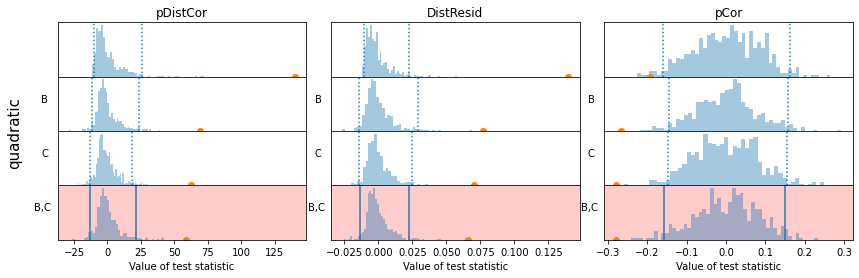

In [132]:
net = 2
samples = 150
parametrization = "quadratic"

model_name = f"net{net}-{samples}-{parametrization}"
pair = ["A", "D"]
methods = ["DistCor", "DistResid", "partial_Cor"]
conditioning_size = 1
threshold = 5
where_to_dir = where_data + f"net{net}/"
num_vars = 4
t, b, d, s = get_all_stats_dict_lists(where_to_dir, model_name, pair, num_vars, methods)
method_name = {"DistCor": "pDistCor", "DistResid":"DistResid", "partial_Cor":"pCor"}

fig, axs = plt.subplots(4, 3, sharex='col', gridspec_kw={'hspace': 0, 'wspace':0.1, "left":0.07, "right":0.99}, figsize=(12, 4))
for i, method in enumerate(methods):
    plot_all_conditionings_summarized(t[method], b[method], s[method], threshold, d[method], axs[:, i], bins=50)
    axs[0, i].set_title(method_name[method])
    axs[3, i].set_xlabel("Value of test statistic")
fig.text(0.02, 0.5, f"{parametrization}", ha='center', va='center', rotation='vertical', size=15)
plt.savefig(f'Distributions_for_Net{net}-{samples}-{parametrization}.png', dpi=600)

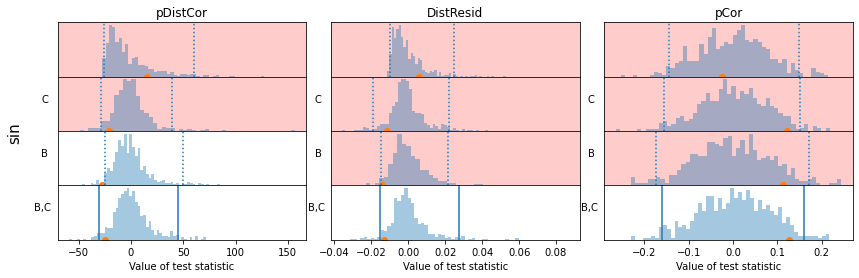

In [133]:
net = 2
samples = 150
parametrization = "sin"

model_name = f"net{net}-{samples}-{parametrization}"
pair = ["A", "D"]
methods = ["DistCor", "DistResid", "partial_Cor"]
conditioning_size = 1
threshold = 5
where_to_dir = where_data + f"net{net}/"
num_vars = 4
t, b, d, s = get_all_stats_dict_lists(where_to_dir, model_name, pair, num_vars, methods)
method_name = {"DistCor": "pDistCor", "DistResid":"DistResid", "partial_Cor":"pCor"}

fig, axs = plt.subplots(4, 3, sharex='col', gridspec_kw={'hspace': 0, 'wspace':0.1, "left":0.07, "right":0.99}, figsize=(12, 4))
for i, method in enumerate(methods):
    plot_all_conditionings_summarized(t[method], b[method], s[method], threshold, d[method], axs[:, i], bins=50)
    axs[0, i].set_title(method_name[method])
    axs[3, i].set_xlabel("Value of test statistic")
fig.text(0.02, 0.5, f"{parametrization}", ha='center', va='center', rotation='vertical', size=15)
plt.savefig(f'Distributions_for_Net{net}-{samples}-{parametrization}.png', dpi=600)

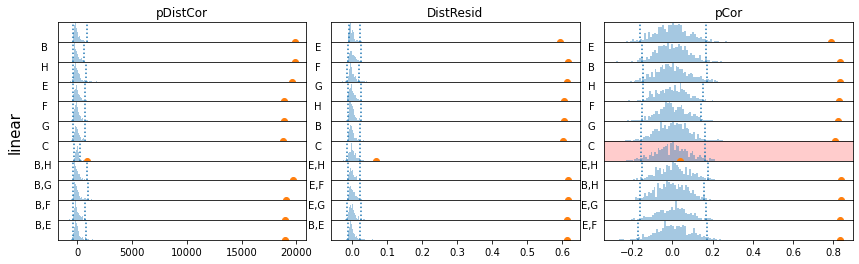

In [151]:
net = 4
samples = 150
parametrization = "linear"

model_name = f"net{net}-{samples}-{parametrization}"
pair = ["A", "D"]
methods = ["DistCor", "DistResid", "partial_Cor"]
conditioning_size = 1
threshold = 5
where_to_dir = where_data + f"net{net}/"
num_vars = 8
t, b, d, s = get_all_stats_dict_lists(where_to_dir, model_name, pair, 8, methods)
method_name = {"DistCor": "pDistCor", "DistResid":"DistResid", "partial_Cor":"pCor"}

fig, axs = plt.subplots(11, 3, sharex='col', gridspec_kw={'hspace': 0, 'wspace':0.1, "left":0.07, "right":0.99}, figsize=(12, 4))
for i, method in enumerate(methods):
    plot_all_conditionings_summarized(t[method], b[method], s[method], threshold, d[method], axs[:, i], bins=50, m=10)
    axs[0, i].set_title(method_name[method])
    axs[3, i].set_xlabel("Value of test statistic")
fig.text(0.02, 0.5, f"{parametrization}", ha='center', va='center', rotation='vertical', size=15)
plt.savefig(f'Distributions_for_Net{net}-{samples}-{parametrization}.png', dpi=600)